In [1]:
import pandas as pd
df = pd.read_csv("online_retail.csv")

In [2]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2022-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2022-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2022-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.isnull().sum() # Checking the duplicate value

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [4]:
# Remove duplicates
df = df.drop_duplicates()
print("After removing duplicates:", df.shape)

After removing duplicates: (536641, 8)


In [5]:
# Cleaning the data
df.dropna(subset=['CustomerID'], inplace=True) #Remove rows with missing CustomerID
df = df[~df['InvoiceNo'].astype(str).str.startswith('C')] #Exclude cancelled invoices (InvoiceNo starting with 'C')
df = df[(df['Quantity'] > 0) & (df['UnitPrice'] > 0)] #Remove negative or zero quantities and prices

df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

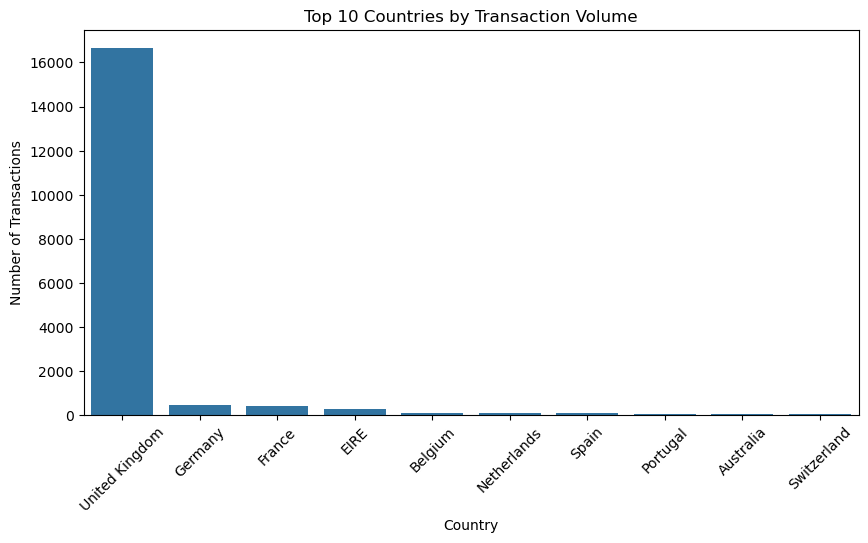

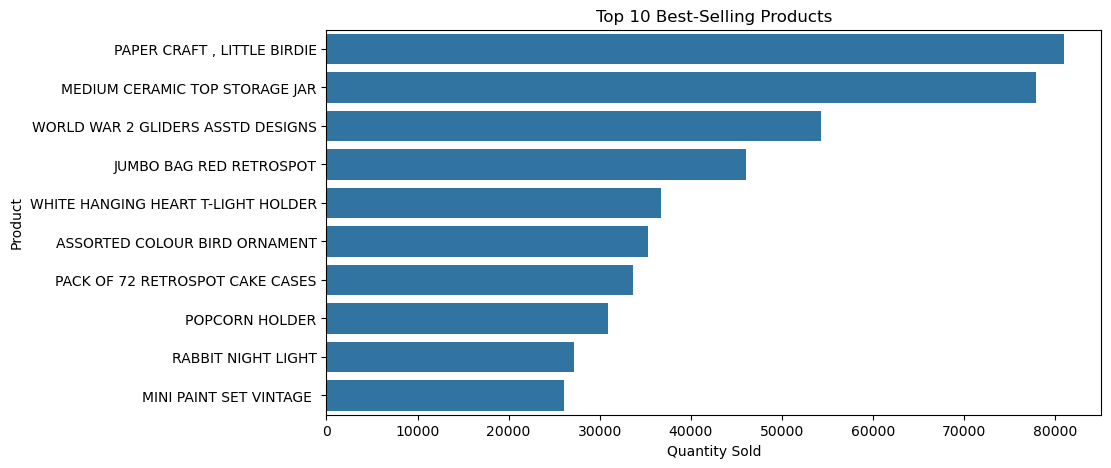

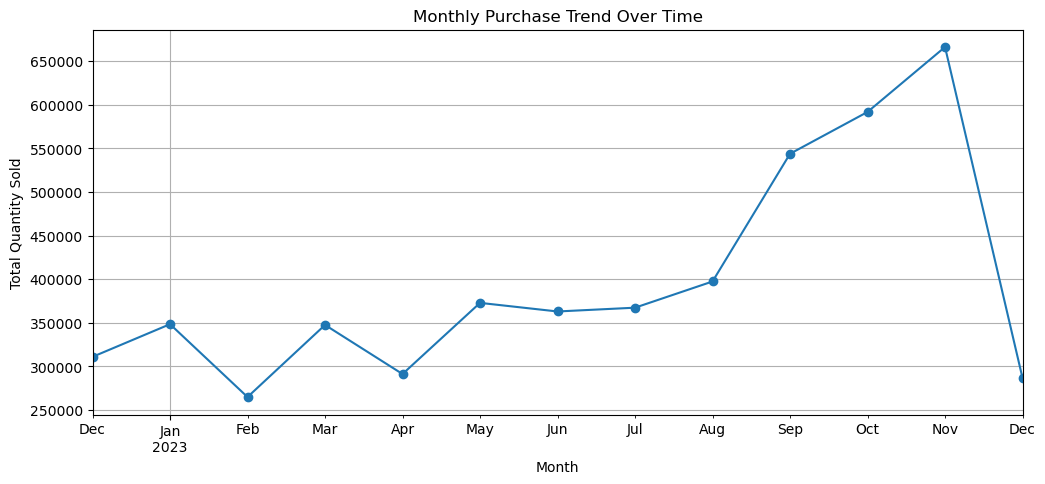

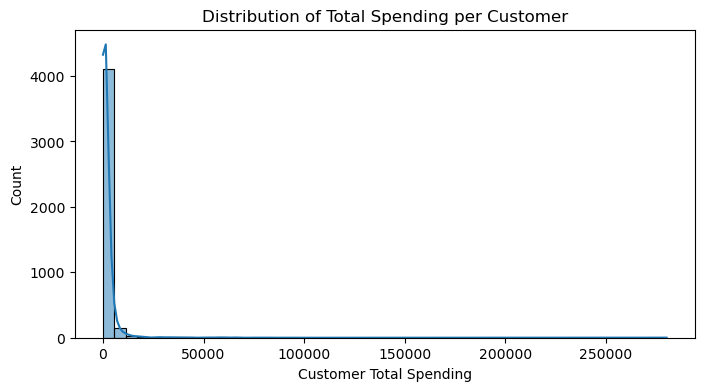

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Transaction Volume by Country
country_sales = df.groupby('Country')['InvoiceNo'].nunique().sort_values(ascending=False).head(10)

plt.figure(figsize=(10,5))
sns.barplot(x=country_sales.index, y=country_sales.values)
plt.title("Top 10 Countries by Transaction Volume")
plt.ylabel("Number of Transactions")
plt.xticks(rotation=45)
plt.show()

# 2. Top-Selling Products

top_products = df.groupby('Description')['Quantity'].sum().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,5))
sns.barplot(x=top_products.values, y=top_products.index)
plt.title("Top 10 Best-Selling Products")
plt.xlabel("Quantity Sold")
plt.ylabel("Product")
plt.show()

# 3. Purchase Trends Over Time
from datetime import datetime
# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Aggregate monthly sales
df['Month'] = df['InvoiceDate'].dt.to_period('M')
monthly_sales = df.groupby('Month')['Quantity'].sum()

plt.figure(figsize=(12,5))
monthly_sales.plot(kind='line', marker='o')
plt.title("Monthly Purchase Trend Over Time")
plt.xlabel("Month")
plt.ylabel("Total Quantity Sold")
plt.grid(True)
plt.show()

# 4. Monetary Distribution per Transaction and Customer
# Total transaction amount per invoice
df['TotalPrice'] = df['Quantity'] * df['UnitPrice']

# Customer-level total spend
customer_sales = df.groupby('CustomerID')['TotalPrice'].sum()

plt.figure(figsize=(8,4))
sns.histplot(customer_sales, bins=50, kde=True)
plt.title("Distribution of Total Spending per Customer")
plt.xlabel("Customer Total Spending")
plt.show()


In [7]:
# RFM Feature Engineering

ref_date = df['InvoiceDate'].max() + pd.Timedelta(days=1)

rfm = df.groupby('CustomerID').agg({
    'InvoiceDate': lambda x: (ref_date - x.max()).days,  # Recency
    'InvoiceNo': 'nunique',                              # Frequency
    'TotalPrice': 'sum'                                  # Monetary
}).rename(columns={'InvoiceDate': 'Recency',
                   'InvoiceNo': 'Frequency',
                   'TotalPrice': 'Monetary'}).reset_index()

print("RFM table created")
rfm.to_csv("rfm_cleaned.csv", index=False)
print(rfm.head())

RFM table created
   CustomerID  Recency  Frequency  Monetary
0     12346.0      326          1  77183.60
1     12347.0        2          7   4310.00
2     12348.0       75          4   1797.24
3     12349.0       19          1   1757.55
4     12350.0      310          1    334.40


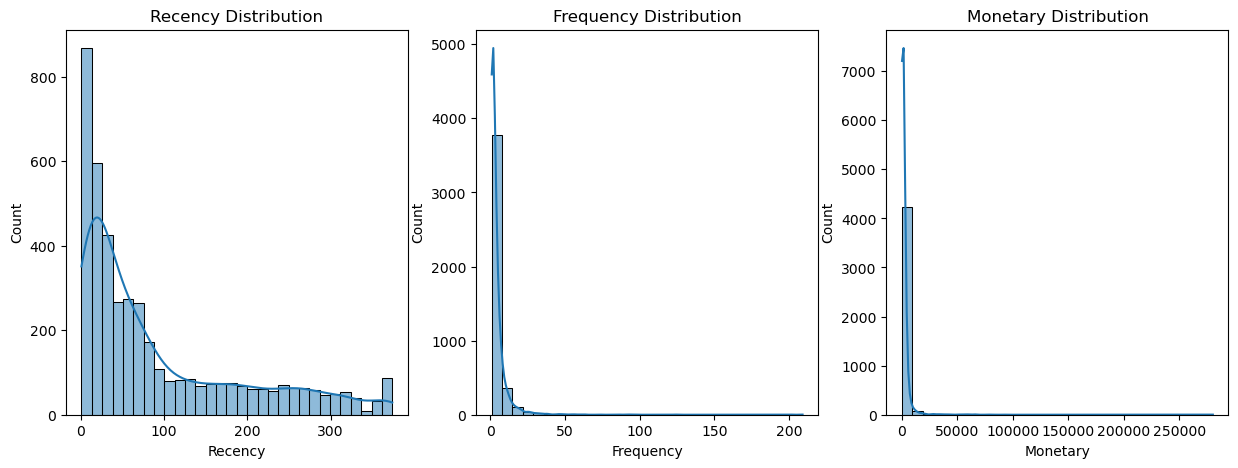

In [8]:
# 5. Visualize distributions
fig, axes = plt.subplots(1, 3, figsize=(15,5))
sns.histplot(rfm['Recency'], bins=30, ax=axes[0], kde=True)
sns.histplot(rfm['Frequency'], bins=30, ax=axes[1], kde=True)
sns.histplot(rfm['Monetary'], bins=30, ax=axes[2], kde=True)
axes[0].set_title('Recency Distribution')
axes[1].set_title('Frequency Distribution')
axes[2].set_title('Monetary Distribution')
plt.show()

In [9]:
# Data Transformation & Scaling
from sklearn.preprocessing import StandardScaler
rfm_log = rfm.copy()
rfm_log['Recency_log'] = np.log1p(rfm_log['Recency'])
rfm_log['Frequency_log'] = np.log1p(rfm_log['Frequency'])
rfm_log['Monetary_log'] = np.log1p(rfm_log['Monetary'])

rfm_features = rfm_log[['Recency_log', 'Frequency_log', 'Monetary_log']]

scaler = StandardScaler()
rfm_scaled = scaler.fit_transform(rfm_features)
rfm_scaled_df = pd.DataFrame(rfm_scaled, columns=['Recency', 'Frequency', 'Monetary'])

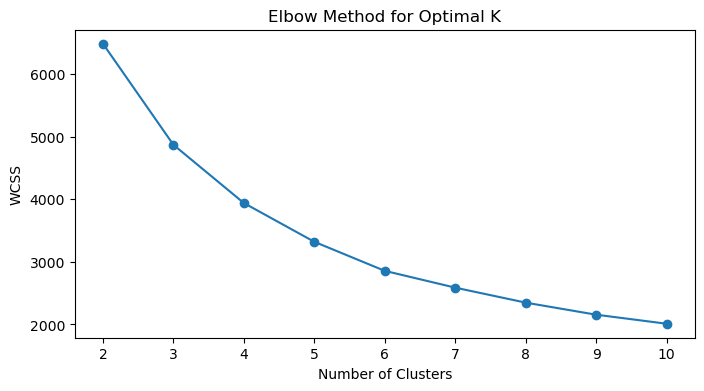

In [10]:
# 6. Elbow method
from sklearn.cluster import KMeans

wcss = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(rfm_scaled)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(8,4))
plt.plot(range(2, 11), wcss, marker='o')
plt.title("Elbow Method for Optimal K")
plt.xlabel("Number of Clusters")
plt.ylabel("WCSS")
plt.show()

In [12]:
from sklearn.cluster import KMeans
final_k = 4
kmeans_final = KMeans(n_clusters=final_k, random_state=42, n_init=10)
rfm['Cluster'] = kmeans_final.fit_predict(rfm_scaled_df)

print(f"\n KMeans clustering completed with {final_k} clusters.")


 KMeans clustering completed with 4 clusters.



Cluster Summary (RFM Means):
         Recency  Frequency  Monetary  Count
Cluster                                     
0          12.17      13.75   8088.02    713
1         181.51       1.32    341.00   1622
2          17.70       2.19    557.32    837
3          71.64       4.08   1801.78   1166


C:\Users\Evangeline T\AppData\Local\Temp\ipykernel_19128\228942452.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x='Cluster', data=rfm, palette='viridis')


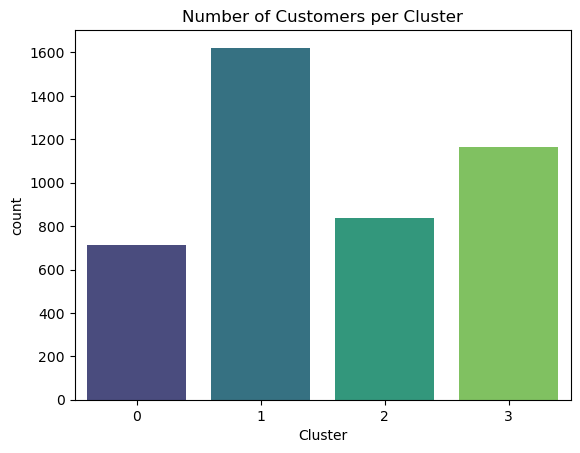

In [13]:
# Cluster Summary

cluster_summary = rfm.groupby('Cluster')[['Recency', 'Frequency', 'Monetary']].mean().round(2)
cluster_summary['Count'] = rfm['Cluster'].value_counts().sort_index()
print("\nCluster Summary (RFM Means):")
print(cluster_summary)

# Sort logically: Low Recency (recent) → High F → High M
cluster_summary = cluster_summary.sort_values(
    by=['Recency', 'Frequency', 'Monetary'],
    ascending=[True, False, False]
)

# 7. Distribution of customers per cluster
sns.countplot(x='Cluster', data=rfm, palette='viridis')
plt.title("Number of Customers per Cluster")
plt.show()

In [14]:
segment_map = {}
for cluster in cluster_summary.index:
    r = cluster_summary.loc[cluster, 'Recency']
    f = cluster_summary.loc[cluster, 'Frequency']
    m = cluster_summary.loc[cluster, 'Monetary']

    if (r <= cluster_summary['Recency'].mean()) and (f >= cluster_summary['Frequency'].mean()) and (m >= cluster_summary['Monetary'].mean()):
        segment_map[cluster] = 'High-Value'
    elif (r <= cluster_summary['Recency'].mean()) and (f >= cluster_summary['Frequency'].mean() / 2):
        segment_map[cluster] = 'Regular'
    elif (r > cluster_summary['Recency'].mean()) and (f <= cluster_summary['Frequency'].mean() / 2):
        segment_map[cluster] = 'At-Risk'
    else:
        segment_map[cluster] = 'Occasional'

# Apply mapping
rfm['Segment_Label'] = rfm['Cluster'].map(segment_map)

print("\nSegment labels assigned successfully.\n")
print(rfm[['CustomerID', 'Recency', 'Frequency', 'Monetary', 'Cluster', 'Segment_Label']].head())


Segment labels assigned successfully.

   CustomerID  Recency  Frequency  Monetary  Cluster Segment_Label
0     12346.0      326          1  77183.60        3    Occasional
1     12347.0        2          7   4310.00        0    High-Value
2     12348.0       75          4   1797.24        3    Occasional
3     12349.0       19          1   1757.55        2    Occasional
4     12350.0      310          1    334.40        1       At-Risk


In [16]:
# Save Models & Label Mapping
import pickle

with open('kmeans_model.pkl', 'wb') as f:
    pickle.dump(kmeans_final, f)

with open('scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

with open('segment_labels.pkl', 'wb') as f:
    pickle.dump(segment_map, f)

print("\n Model, scaler, and label mapping saved successfully")


 Model, scaler, and label mapping saved successfully



 Product matrix created: (4338, 3877)


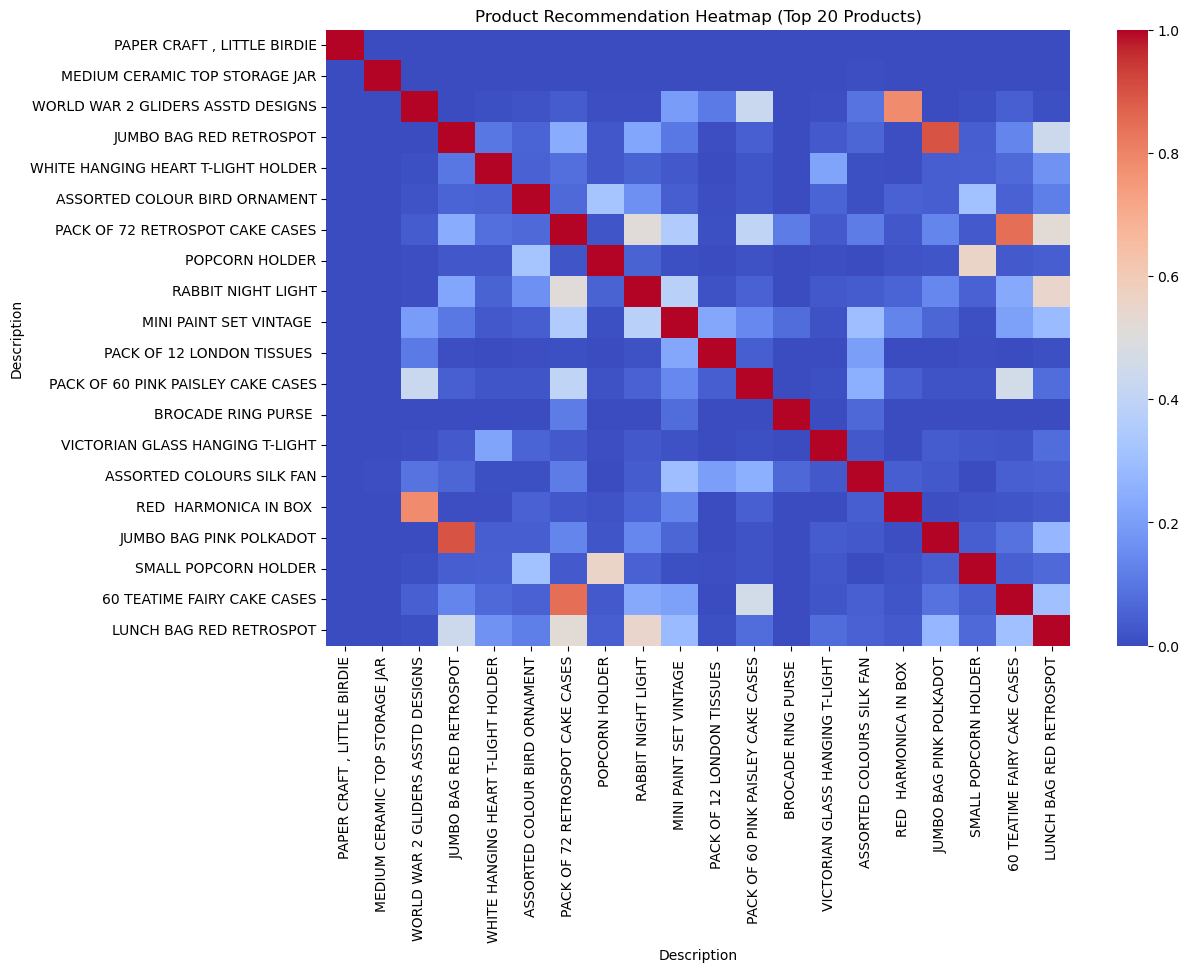

Item similarity matrix and product list saved successfully


In [17]:
# Item-Based Collaborative Filtering
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
product_matrix = df.pivot_table(
    index='CustomerID',
    columns='Description',
    values='Quantity',
    aggfunc='sum',
    fill_value=0
)
print(f"\n Product matrix created: {product_matrix.shape}")

item_similarity = cosine_similarity(product_matrix.T)
item_similarity_df = pd.DataFrame(
    item_similarity,
    index=product_matrix.columns,
    columns=product_matrix.columns
)

# 8. Product Recommendation Heatmap for 20 products

top_items = product_matrix.sum().sort_values(ascending=False).head(20).index
plt.figure(figsize=(12,8))
sns.heatmap(item_similarity_df.loc[top_items, top_items], cmap='coolwarm')
plt.title("Product Recommendation Heatmap (Top 20 Products)")
plt.show()


# Save similarity matrix
with open('item_similarity.pkl', 'wb') as f:
    pickle.dump(item_similarity_df, f)

# Also save product list for Streamlit dropdowns
product_list = list(product_matrix.columns)
with open('products.pkl', 'wb') as f:
    pickle.dump(product_list, f)

print("Item similarity matrix and product list saved successfully")
